In [2]:
import kagglehub
import os
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from torch.utils.data import TensorDataset, DataLoader

/home/hle12/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Download the dataset
path = kagglehub.dataset_download("fahmidachowdhury/domestic-violence-against-women")

# List files in the directory to find the CSV
csv_files = [f for f in os.listdir(path) if f.endswith(".csv")]

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {path}")

# Construct path to the CSV file
csv_path = os.path.join(path, csv_files[0])

# Load the CSV into a DataFrame
dataframe = pd.read_csv(csv_path)

In [4]:
print(dataframe.head())

   SL. No  Age Education  Employment   Income Marital status  Violence 
0       1   30  secondary  unemployed       0         married       yes
1       2   47   tertiary  unemployed       0         married        no
2       3   24   tertiary  unemployed       0        unmarred        no
3       4   22   tertiary  unemployed       0        unmarred        no
4       5   50    primary  unemployed       0         married       yes


# Checking the reliability of data and data cleaning

<b> Interesting observation(s): </b>

⭐ 75.22% of the dataset contains are of non-violent households, indicating an class-unbalanced.

⭐ Around 86.08% of records contain an income of 0. There are many reasons why this may be the case: 
- Missing income data are default to 0
- There may be biases during the retrieval of data
- Domestic violence are more easily recorded among low-income households.

<b> Change(s) made: </b>

⭐ Remove leading and trailing spaces of String data and column labels

⭐ Added a column 'Age group' that group data in the column 'Age' into intervals of 10.

In [5]:
# Print out column labels for checking

print(dataframe.columns.tolist())

['SL. No', 'Age', 'Education ', 'Employment ', 'Income', 'Marital status ', 'Violence ']


In [6]:
# Noticeably, some of the column names contain trailing white spaces which we will remove.

dataframe.columns = dataframe.columns.str.strip()
print(dataframe.columns.tolist())

['SL. No', 'Age', 'Education', 'Employment', 'Income', 'Marital status', 'Violence']


In [7]:
# Count NA values in each column
dataframe.isna().sum()

SL. No            0
Age               0
Education         0
Employment        0
Income            0
Marital status    0
Violence          0
dtype: int64

In [8]:
# Make SL. No my index column

dataframe = dataframe.set_index('SL. No')

In [9]:
# Ensure consistency of data type of each column

dataframe.dtypes

Age                int64
Education         object
Employment        object
Income             int64
Marital status    object
Violence          object
dtype: object

In [10]:
# Check unique values of columns where the datatype is String
string_cols = dataframe.select_dtypes(include='object').columns

# Print out the unique values of these columns
for col in string_cols:
    print(f"--- {col} ---")
    print(dataframe[col].unique())
    print()

--- Education ---
['secondary' 'tertiary' 'primary' 'none']

--- Employment ---
['unemployed' 'semi employed' 'employed' 'employed ']

--- Marital status ---
['married' 'unmarred']

--- Violence ---
['yes' 'no']



In [11]:
# Noticeably, some of the data contains trailing spaces which we will remove. 

# Remove trailing spaces for String data type
dataframe = dataframe.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

string_cols = dataframe.select_dtypes(include='object').columns

# Present the new unique values of String columns
for col in string_cols:
    print(f"--- {col} ---")
    print(dataframe[col].unique())
    print()

--- Education ---
['secondary' 'tertiary' 'primary' 'none']

--- Employment ---
['unemployed' 'semi employed' 'employed']

--- Marital status ---
['married' 'unmarred']

--- Violence ---
['yes' 'no']



In [12]:
# Check if the dataset is class-balanced (roughly equal number of violent and non-violent relationship)
# Result shows that there are more non-violent data than violent.

# Calculate the total number of data
total_data = len(dataframe['Violence'])

# Calculate total number of yes and no in the Violence column
count_per_categories = dataframe['Violence'].value_counts()

# Calculate the percentage
category_percentage = (count_per_categories / total_data) * 100

# Present the percentage in a DataFrame
violence_statistics = pd.DataFrame({
    'Count per categories': count_per_categories,
    'Percentage': category_percentage.round(2)  
})

print(violence_statistics)

          Count per categories  Percentage
Violence                                  
no                         261       75.22
yes                         86       24.78


In [13]:
# Obtain the data information of numeric columns including min, max, mode, average
# An interesting observation seen is that the Q1, median and Q3 for the Income column is zero
# This indicates that most households in the dataset is low-income, as shown below.

dataframe.describe().round(1)

,Age,Income
count,347.0,347.0
mean,31.4,2110.7
std,9.6,5743.3
min,15.0,0.0
25%,23.0,0.0
50%,30.0,0.0
75%,39.5,0.0
max,60.0,35000.0


In [14]:
# Calculate the percentage of income level that made up the top 10 income level based on frequency.

# Calculate the total number of each income level for the top 10 income level.
count_per_top_10_income = dataframe['Income'].value_counts().head(10)

# Calculate the total number of data points
income_count = count_per_top_10_income.sum()

# Calculate the income percentage
income_percentage = (count_per_top_10_income / income_count) * 100

# Create a DataFrame of the data
income_summary = pd.DataFrame({
    'Count': count_per_top_10_income,
    'Percentage': income_percentage.round(2)  
})

print(income_summary)

        Count  Percentage
Income                   
0         272       86.08
5000        8        2.53
3000        6        1.90
2000        5        1.58
22000       5        1.58
4000        4        1.27
15000       4        1.27
6000        4        1.27
2500        4        1.27
10000       4        1.27


In [15]:
# Because age is continuous, it might be helpful to the model to group entries according to age groups
# Note: it has been previously established that the minimum age is 15 and maximum age is 60.

# Define the bin edges for age groups (ages 15 to 65 in 10-year intervals)
bin_edges = [15, 25, 35, 45, 55, 65]

# Define the labels for each corresponding age group
age_groups = [
    "15 ≤ age < 25",
    "25 ≤ age < 35",
    "35 ≤ age < 45",
    "45 ≤ age < 55",
    "55 ≤ age < 65"
]

# Create a new column 'Age group' by binning the 'Age' column into defined intervals
# 'right=False' means the intervals are left-inclusive, i.e., [15,25) includes 15 but not 25
dataframe['Age group'] = pd.cut(dataframe['Age'], bins=bin_edges, labels=age_groups, right=False)

In [16]:
dataframe.head().style.set_properties()

,Age,Education,Employment,Income,Marital status,Violence,Age group
SL. No,,,,,,,
1,30,secondary,unemployed,0,married,yes,25 ≤ age < 35
2,47,tertiary,unemployed,0,married,no,45 ≤ age < 55
3,24,tertiary,unemployed,0,unmarred,no,15 ≤ age < 25
4,22,tertiary,unemployed,0,unmarred,no,15 ≤ age < 25
5,50,primary,unemployed,0,married,yes,45 ≤ age < 55


# Neural Network Model

<b> Goal: Binary Classification </b>

Being able to predict whether domestic violence is present in a relationship based on socio-economic factors including:
- Age
- Education
- Employment
- Income
- Marital Status
- Age group



<b> Explanations of hyperparameter choices: </b>

⭐ The dataset is split accordingly into train, test and validation data based on the ratio 80:10:10.

⭐ Seed number is 42 because, after random testing and trials, ~0.77 is the ceiling / maximum achievable accuracy.

⭐ Epoch number is 125 because visualisation when epoch is 200 shows that, after 125, validation loss stops improving. Testing with epoch numbers between 120-130 were also manually done to prove this.

⭐ The chosen threshold is 0.5. I determined the best threshold by analyzing both the ROC curve and the precision-recall curve, as well as through trial and error. Among these methods, trial and error showed that a threshold of 0.5 gives the highest accuracy.

<b> Explanations of other choices made: </b>

⭐ Stratified sampling are done using sklearn to take into account class-unbalanced.
- Due to the dataset not being class-balanced, random sampling may introduce biases.

⭐ SMOTE is used on the training data set to balance the data and improve learning. It also yields a higher accuracy than changing the weight of positive examples.

⭐ Despite the small dataset, Pytorch is used (instead of scikit-learn) to improve customisability.

⭐ Because Pytorch is used, we are converting non-numerical data to numerical through mapping.

In [17]:
# Check unique values of columns where the datatype is String
string_cols = dataframe.select_dtypes(include='object').columns

for col in string_cols:
    print(f"--- {col} ---")
    print(dataframe[col].unique())
    print()

dataframe['Age group'].dtypes

--- Education ---
['secondary' 'tertiary' 'primary' 'none']

--- Employment ---
['unemployed' 'semi employed' 'employed']

--- Marital status ---
['married' 'unmarred']

--- Violence ---
['yes' 'no']



CategoricalDtype(categories=['15 ≤ age < 25', '25 ≤ age < 35', '35 ≤ age < 45',
                  '45 ≤ age < 55', '55 ≤ age < 65'],
, ordered=True, categories_dtype=object)

In [18]:
# Convert non-numeric data to numeric because Pytorch uses tensors.

# Assign numberical value to categories
Education_map = {
    'none': 0,
    'primary': 1,
    'secondary': 2,
    'tertiary': 3
}

Employment_map = {
    'unemployed': 0,
    'semi employed': 1,
    'employed': 2,
}

Marital_status_map = {
    'unmarred': 0,
    'married': 1,
}

Violence_map = {
    'no': 0,
    'yes': 1,
}

Age_group_map = {
    "15 ≤ age < 25": 0,
    "25 ≤ age < 35": 1,
    "35 ≤ age < 45": 2,
    "45 ≤ age < 55": 3,
    "55 ≤ age < 65": 4
}

numeric_df = dataframe.copy()

# Map category data to numerical values 
numeric_df['Education'] = numeric_df['Education'].map(Education_map)
numeric_df['Employment'] = numeric_df['Employment'].map(Employment_map)
numeric_df['Marital status'] = numeric_df['Marital status'].map(Marital_status_map)
numeric_df['Violence'] = numeric_df['Violence'].map(Violence_map)
numeric_df['Age group'] = numeric_df['Age group'].map(Age_group_map)

In [19]:
numeric_df.head().style.set_properties()

,Age,Education,Employment,Income,Marital status,Violence,Age group
SL. No,,,,,,,
1,30,2,0,0,1,1,1
2,47,3,0,0,1,0,3
3,24,3,0,0,0,0,0
4,22,3,0,0,0,0,0
5,50,1,0,0,1,1,3


In [20]:
# Creating the training and testing data

X = numeric_df.copy().drop('Violence', axis = 1)
y = numeric_df['Violence']


# Stratified split into train + temp (validation+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Then split temp into validation and test sets (equal halves here)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [21]:
# Check to make sure the class proportions of the training, validation and testing sets are roughly the same,

print(y.value_counts(normalize=True))
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Violence
0    0.752161
1    0.247839
Name: proportion, dtype: float64
Violence
0    0.750903
1    0.249097
Name: proportion, dtype: float64
Violence
0    0.771429
1    0.228571
Name: proportion, dtype: float64


In [22]:
# Because we are using Pytorch, convert the dtype of sets from float64 to tensor.float32.
def convert(dataset):
    return torch.tensor(dataset.values, dtype=torch.float32)


X_train = convert(X_train)

# Add a new dimension of size 1 to tensors of y sets.
# This matches the shapes of the model output with the target labels.
y_train = convert(y_train).unsqueeze(1)
X_val = convert(X_val)
y_val = convert(y_val).unsqueeze(1)
X_test = convert(X_test)
y_test = convert(y_test).unsqueeze(1)

In [23]:
print(X.shape)
print(X_train.shape)

(347, 6)
torch.Size([277, 6])


In [24]:
# Set a fixed random seed for reproducibility
seed = 42

torch.manual_seed(seed)                  # Set seed for PyTorch CPU and CUDA
random.seed(seed)                        # Set seed for Python's built-in random module
np.random.seed(seed)                     # Set seed for NumPy random functions

# Configure PyTorch to use deterministic algorithms
torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior when using cuDNN 
torch.backends.cudnn.benchmark = False     # Disables dynamic algorithm selection for consistent results


In [25]:
y_train = y_train.float()
y_val = y_val.float()
y_test = y_test.float()

In [26]:
# Suppose X_train and y_train are torch tensors
X_train_np = X_train.numpy()
y_train_np = y_train.numpy()

# Apply SMOTE
smote = SMOTE(random_state=seed)
X_resampled, y_resampled = smote.fit_resample(X_train_np, y_train_np)

# Convert back to torch tensors
X_resampled_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_resampled_tensor = torch.tensor(y_resampled, dtype=torch.float32).unsqueeze(1)  # shape: [N, 1]

# Create TensorDataset
dataset_resampled = TensorDataset(X_resampled_tensor, y_resampled_tensor)

# Create DataLoader
train_loader = DataLoader(dataset_resampled, batch_size=32, shuffle=True)


In [27]:
# Original training labels
original_counts = Counter(y_train.numpy().ravel())

# After SMOTE
smote_counts = Counter(y_resampled.ravel())

# Create DataFrame
df = pd.DataFrame({
    "Original Count": original_counts,
    "After SMOTE": smote_counts
}).rename_axis("Class").reset_index()

print(df)

   Class  Original Count  After SMOTE
0    0.0             208          208
1    1.0              69          208


In [28]:
# Create Model
model = nn.Sequential(
    nn.Linear(6, 32),   # input layer to first hidden layer
    nn.ReLU(),
    nn.Linear(32, 16),  # second hidden layer
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU(),
    nn.Linear(32, 1)    # output layer
)

# Create loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
logits = model(X_test) 
probs = torch.sigmoid(logits)
pred_labels = (probs >= 0.5).int()

In [30]:
# Lists to store loss values for plotting or analysis
test_loss_store = []
val_loss_store = []

# Training loop for 125 epochs
for epoch in range(125):
    model.train()  # Set model to training mode

    # Iterate through batches in the training DataLoader
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch).squeeze(1)      # Model prediction, shape: [batch_size]
        y_batch = y_batch.float().squeeze(1)    # Ensure y_batch matches shape and type

        loss = loss_fn(y_pred, y_batch)         # Compute training loss

        # Backpropagation
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update model parameters

    # Evaluation on validation set
    model.eval()  # Set model to evaluation mode
    with torch.inference_mode():  # Disable gradient calculation for efficiency
        y_val_pred = model(X_val).squeeze(1)                 # Predict on validation data
        val_loss = loss_fn(y_val_pred, y_val.squeeze(1))     # Compute validation loss

    # Store and print losses every 10 epochs
    if epoch % 10 == 0:
        test_loss_store.append(loss.item())         # Save last training batch's loss
        val_loss_store.append(val_loss.item())      # Save validation loss

        # Print progress
        print(f"Epoch {epoch:03d} | "
              f"Train loss: {loss.item():.4f} | "
              f"Val loss: {val_loss.item():.4f}")


Epoch 000 | Train loss: 0.7270 | Val loss: 0.7091
Epoch 010 | Train loss: 0.6895 | Val loss: 0.7242
Epoch 020 | Train loss: 0.6953 | Val loss: 0.7547
Epoch 030 | Train loss: 0.7267 | Val loss: 0.6549
Epoch 040 | Train loss: 0.7044 | Val loss: 0.7559
Epoch 050 | Train loss: 0.6542 | Val loss: 0.6638
Epoch 060 | Train loss: 0.6524 | Val loss: 0.6771
Epoch 070 | Train loss: 0.6305 | Val loss: 0.6758
Epoch 080 | Train loss: 0.6420 | Val loss: 0.6214
Epoch 090 | Train loss: 0.6555 | Val loss: 0.6288
Epoch 100 | Train loss: 0.6490 | Val loss: 0.6249
Epoch 110 | Train loss: 0.6811 | Val loss: 0.6327
Epoch 120 | Train loss: 0.6430 | Val loss: 0.6232


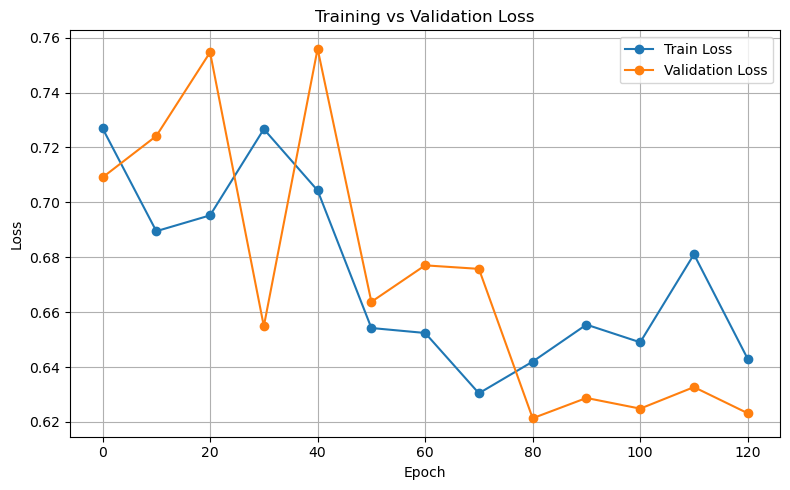

In [31]:
# Visualise the changes in training loss and validation loss over epochs.
epochs = list(range(0, 125, 10))

plt.figure(figsize=(8, 5))
plt.plot(epochs, test_loss_store, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_store, label='Validation Loss', marker='o')

plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<b> Evaluation of loss numbers: </b>
- Loss are decreasing steadily for both but with fluctuations.
- Fluctuations may be caused by stochasticity in the validation set.
- Training and evaluation losses are close together at the end with validation loss lower than training loss. This means that the model is performing better on unnseen validation data.
- There’s no strong evidence of overfitting here. Overfitting would show as training loss continuing downward while validation loss plateaus or rises.

In [32]:
# Test on test sets
with torch.inference_mode(): # Disable gradient tracking for faster and safer evaluation
    
    y_test_pred = model(X_test) # Get predicted probabilities from the model
    
    y_test_labels = (y_test_pred >= 0.5).float() # Convert probabilities to binary predictions using threshold 0.5

    test_loss = loss_fn(y_test_pred, y_test)  # Calculate test loss using the original probabilities and true labels

    print(f"Test loss: {test_loss.item():.4f}")


accuracy = accuracy_score(y_test, y_test_labels) # Compare predicted labels to true labels
print(f"Test Accuracy: {accuracy:.4f}")

Test loss: 0.6551
Test Accuracy: 0.7714


In [33]:
# Create a confusion matrix for evaluation
print(confusion_matrix(y_test, y_test_labels))

[[21  6]
 [ 2  6]]


In [34]:
# Detach values from graph and move to CPU for sklearn 
y_true = y_test.cpu().numpy()
y_pred = y_test_labels.cpu().numpy()

# Create a classification report for evaluation
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9130    0.7778    0.8400        27
         1.0     0.5000    0.7500    0.6000         8

    accuracy                         0.7714        35
   macro avg     0.7065    0.7639    0.7200        35
weighted avg     0.8186    0.7714    0.7851        35



In [41]:
# Train another model without SMOTE and stratified sampling for comparison

X = numeric_df.copy().drop('Violence', axis = 1)
y = numeric_df['Violence']

# First split: train + temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)

# Second split: validation + test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True
)

# Convert to torch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_val   = torch.tensor(X_val.values, dtype=torch.float32)
X_test  = torch.tensor(X_test.values, dtype=torch.float32)

y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_val   = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
y_test  = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)


# Define model
model = nn.Sequential(
    nn.Linear(6, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU(),
    nn.Linear(32, 1)  # binary classification -> 1 output
)

# Loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 125
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()

    # Forward pass on *all* training data
    y_pred = model(X_train)                 # shape [277,1]
    loss = loss_fn(y_pred, y_train)         # shape matches!

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.inference_mode():
        y_val_pred = model(X_val)
        val_loss = loss_fn(y_val_pred, y_val)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

# Final test evaluation
model.eval()
with torch.inference_mode():
    y_test_pred = model(X_test)
    test_loss = loss_fn(y_test_pred, y_test)

    y_test_labels = (torch.sigmoid(y_test_pred) >= 0.5).float()
    acc = accuracy_score(y_test, y_test_labels)

print(f"\nTest Loss: {test_loss.item():.4f}")
print(f"Test Accuracy: {acc:.4f}")
print(classification_report(y_test, y_test_labels))

Epoch 000 | Train Loss: 2.1805 | Val Loss: 8.6718
Epoch 010 | Train Loss: 0.5803 | Val Loss: 1.2955
Epoch 020 | Train Loss: 0.7708 | Val Loss: 1.9784
Epoch 030 | Train Loss: 0.5603 | Val Loss: 1.0004
Epoch 040 | Train Loss: 0.6657 | Val Loss: 1.4033
Epoch 050 | Train Loss: 0.5632 | Val Loss: 0.9066
Epoch 060 | Train Loss: 0.5650 | Val Loss: 0.6141
Epoch 070 | Train Loss: 0.5542 | Val Loss: 0.6965
Epoch 080 | Train Loss: 0.5532 | Val Loss: 0.7447
Epoch 090 | Train Loss: 0.5500 | Val Loss: 0.7326
Epoch 100 | Train Loss: 0.5470 | Val Loss: 0.7063
Epoch 110 | Train Loss: 0.5423 | Val Loss: 0.6906
Epoch 120 | Train Loss: 0.5374 | Val Loss: 0.6811

Test Loss: 0.6712
Test Accuracy: 0.6981
              precision    recall  f1-score   support

         0.0       0.70      1.00      0.82        37
         1.0       0.00      0.00      0.00        16

    accuracy                           0.70        53
   macro avg       0.35      0.50      0.41        53
weighted avg       0.49      0.70    

/home/hle12/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hle12/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hle12/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<b> Evaluation of model: </b>

⭐ With about 75% no violence and 25% violence, a naive baseline model that always predicts the majority class ("no violence") would get about 75% accuracy. The model's accuracy is 77.14% which is higher than this baseline accuracy. However, this difference is not substantial. 

⭐ Without SMOTE and Stratified Sampling, the model achieved the same accuracy but completely failed to detect the minority class (F1 = 0). With SMOTE, accuracy only increased by 10.2%, but recall for the minority class improved from 0.00 to 0.75. In real-world safety contexts, this improvement in recall is useful if the model is used to identify positive cases (domestic violence incidents).

⭐ While precision for predicting class 1 is only 0.5, only 24.78% of the dataset is class 1. Consequently, a precision of 0.5 is relatively reasonable for this class imbalance.

⭐ Both the test loss (0.6551) and the accuracy (0.7714) of the model is moderately high indicating that while the model is making many correct predictions, confidence is low. This may be because, due to imbalanced class, the model becomes unconfident in predicting minority classes. 
